# Question #3:
Does the customer's region have a statistically significant impact on the amount of orders they submit?

### Library and Data Import

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
plt.style.use('ggplot')
import sqlite3
from importlib import reload
from itertools import combinations
from statsmodels.stats.power import tt_ind_solve_power

#Pulling functions generated throughout the course of the module to assist with some of the testing.
import flatiron_stats as fs

#Setting significance level:
a = 0.05
reload(fs)

<module 'flatiron_stats' from 'C:\\Users\\Drew\\flatiron-ds-course\\Mod-3\\dsc-mod-3-project-online-ds-ft-090919\\flatiron_stats.py'>

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

### Hypothesis
H0: Customer Region has no statistically significant effect on number of orders.<br>
HA: Customer Region has a statistically significant effect on number of orders.<br>

### Gathering Data

In [87]:
query = """SELECT COUNT(DISTINCT c.Id) as NumCustomers, COUNT(DISTINCT o.ID) as NumOrders, 
           c.Region as CustomerRegion, (COUNT(DISTINCT o.Id) / COUNT(DISTINCT c.ID)) as AvgOrderPerCustomer
           FROM Customer c
           JOIN 'Order' o
           ON c.Id = o.CustomerID
           GROUP BY 3
           """
pd.read_sql(query, conn)

,NumCustomers,NumOrders,CustomerRegion,AvgOrderPerCustomer
0,8,75,British Isles,9
1,4,21,Central America,5
2,1,7,Eastern Europe,7
3,16,152,North America,9
4,4,55,Northern Europe,13
5,3,28,Scandinavia,9
6,14,127,South America,9
7,9,64,Southern Europe,7
8,26,272,Western Europe,10


Initial review indicates that there is some difference in the average number of orders per customer based on the region. We'll go ahead and create our dataframe and start running through some visualizations to determine the significance. We may end up grouping the regions into Americas and Europe to have larger data pools for comparison.

In [3]:
query = """SELECT c.Id as CustomerID, COUNT(DISTINCT o.ID) as NumOrders, 
           c.Region as CustomerRegion
           FROM Customer c
           JOIN 'Order' o
           ON c.Id = o.CustomerID
           GROUP BY 1
           """
df = pd.read_sql(query, conn)
europe_df = pd.DataFrame()
americas_df = pd.DataFrame()
regiongroup = []
for i in range(len(df)):
    if df.iloc[i]['CustomerRegion'].find('America') >= 0:
        regiongroup.append('Americas')
        americas_df = americas_df.append(df.iloc[i])
    else:
        regiongroup.append('Europe')
        europe_df = europe_df.append(df.iloc[i])
df['CustomerRegionGroup'] = regiongroup
print(len(europe_df))
df.head()

51


,CustomerID,NumOrders,CustomerRegion,CustomerRegionGroup
0,ALFKI,6,Western Europe,Europe
1,ANATR,4,Central America,Americas
2,AROUT,13,British Isles,Europe
3,BERGS,18,Northern Europe,Europe
4,BLAUS,7,Western Europe,Europe


### Visualizing the Data
Exploring the data visually to understand the order values of each region.

Text(0.5, 1.0, 'Number of Orders per Customer Region')

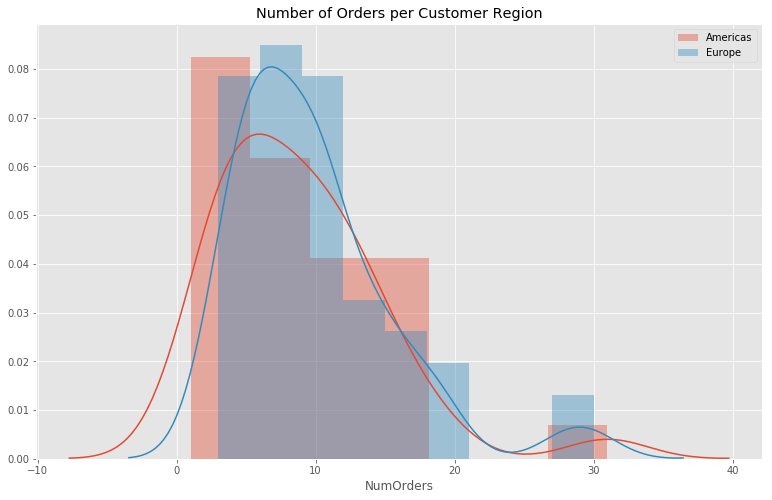

In [4]:
plt.figure(figsize = (13, 8))
sns.distplot(americas_df.NumOrders, label = 'Americas')
sns.distplot(europe_df.NumOrders, label = 'Europe')
plt.legend()
plt.title('Number of Orders per Customer Region')

Text(0.5, 1.0, 'Number of Orders per Customer Region\n(No Outliers)')

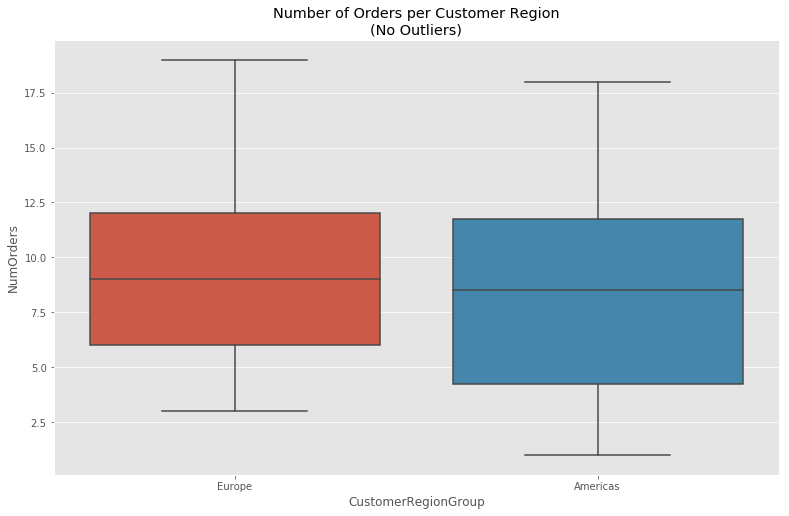

In [5]:
plt.figure(figsize = (13, 8))
sns.boxplot(df.CustomerRegionGroup, df.NumOrders, showfliers = False)
plt.title('Number of Orders per Customer Region\n(No Outliers)')

## Hypothesis Testing
Since the visualizations and table show that there may not be much of a difference, we'll move on to testing to determine whether or not that difference is of a statistical significance. To answer this question, we will perform an Independent T-Test, however, in order to do that, we must first check a couple of assumptions with our data. 1: Our Distributions are Normal, and 2: Our Distributions' Variances are equal.

To restate, our hypothesis is: <br>
H0: Customer Region has no statistically significant effect on number of orders.<br>
HA: Customer Region has a statistically significant effect on number of orders.

### Normality
While there is a hint of normality to each distribution, they both have some degree of positive skew. To determine normality, we'll run KS (Kolmogorov-Smirnov) and Shapiro tests, using our significance value of 0.05.

In [153]:
for region in df.CustomerRegionGroup.unique():
    data = df[df['CustomerRegionGroup'] == region]['NumOrders']
    mu = data.mean()
    std = data.std()
    stat, p = stats.kstest(data, 'norm', args = (mu, std))
    print(f"KS Test for {region}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

KS Test for Europe:
Test Statistic: 0.17412883358761477
P-Value: 0.08013948072214094
Is Normal: True

KS Test for Americas:
Test Statistic: 0.12102252084466075
P-Value: 0.6836717414456377
Is Normal: True



In [154]:
for region in df.CustomerRegionGroup.unique():
    data = df[df['CustomerRegionGroup'] == region]['NumOrders']
    mu = data.mean()
    std = data.std()
    stat, p = stats.shapiro(data)
    print(f"Shapiro Test for {region}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

Shapiro Test for Europe:
Test Statistic: 0.866019606590271
P-Value: 3.693511098390445e-05
Is Normal: False

Shapiro Test for Americas:
Test Statistic: 0.8784148693084717
P-Value: 0.001294453744776547
Is Normal: False



Despite the KS Test showing normality, the Shapiro Test indicates these distributions are not normal, and as it is the more powerful test, we're going to take it's results over the KS test. While a Welch's T-Test is doable with non-normal distributions, in order to better compare each region's effect size, we'll take a number of samples to gather a more normal distribution for each region based on the Central Limit Theorem.

### Sampling and Reviewing

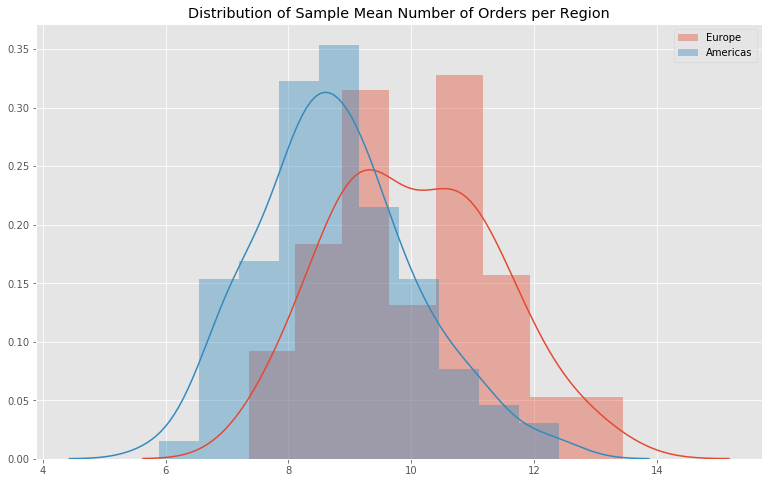

In [159]:
num_samples = 100
sample_size = 20
plt.figure(figsize = (13, 8))
samp_dict = {}
for region in df.CustomerRegionGroup.unique():
    data = df[df['CustomerRegionGroup'] == region]['NumOrders']
    samp_means = []
    for n in range(num_samples):
        sample = np.random.choice(data, size = sample_size, replace = True)
        samp_means.append(sample.mean())
    samp_dict[region] = np.array(samp_means)
    label = region
    sns.distplot(samp_means, label = label)
plt.title('Distribution of Sample Mean Number of Orders per Region')
plt.legend()

In [160]:
for region in df.CustomerRegionGroup.unique():
    data = samp_dict[region]
    stat, p = stats.shapiro(data)
    print(f"Shapiro Test for {region}:\nTest Statistic: {stat}\nP-Value: {p}\nIs Normal: {p > a}\n")

Shapiro Test for Europe:
Test Statistic: 0.985493540763855
P-Value: 0.3444950580596924
Is Normal: True

Shapiro Test for Americas:
Test Statistic: 0.9854674935340881
P-Value: 0.34303048253059387
Is Normal: True



Now that we've got samples that meet our normality assumption, we need to check their variances and determine whether or not they're equal.

### Equal Variance Testing

In [161]:
fs.test_equal_variances(samp_dict['Americas'], samp_dict['Europe'])

p = 0.19822152851814037
Therefore the data have equal variances


True

As our variances are equal, we'll go ahead and use a Student's T-Test to determine the result of our hypothesis.

### Student's T-Test

In [162]:
stats.ttest_ind(samp_dict['Americas'], samp_dict['Europe'])

Ttest_indResult(statistic=-6.79272087090113, pvalue=1.2571276030446462e-10)

With a P-Value less than our significance level, we are able to reject our Null Hypothesis, and determine that there is a statistically significant difference in number of orders based on the customer's region. Because of this, we can move on to determining exactly how much difference there is.

### Effect Size

In [179]:
#Sample Group Effect Sizes
d = fs.cohens_d(samp_dict['Europe'], samp_dict['Americas'])
print(f'Effect Size (d) for Customer Region Sample Set: {d}')

Effect Size (d) for Customer Region Sample Set: 0.9654753037865513


Looking at the sample of means, it does appear that the mean number of orders does vary quite a bit between regions! Next we'll go ahead and calculate our Power to see the likelihood of correctly rejecting our Null Hypothesis.

### Power

In [180]:
tt_ind_solve_power(effect_size=d, nobs1=sample_size, alpha=a)

0.8449808569501598

## Conclusion
After fully testing the sample mean distributions, it does appear that there is a statistically significant difference in number of orders based on customer's region, and with a power of 84.5% we're fairly confident that we are correctly rejecting our Null Hypothesis.

Based on the results and an effect size of .97, I would recommend focusing our sales to customers in the European region, as there is a higher chance of generating a sale, and potentially having a repeat customer as well as the average number of orders per customer is higher for Europe, specifically in Northern and Western Europe.